# PilotNet
This is an end-to-end deep learning architecture for autonomous driving, developed by Nvidia.

It receives as input an image and it outputs a steering angle.

The paper can be found [here](https://arxiv.org/pdf/1704.07911.pdf).

## Details from the paper

The model can be viewed in the following image (from the paper):

![alt text](imgs/architecture.png "PilotNet")

The **training data** consists of images sampled from a fron-facing camera in the car - they also come with the correct steering command (1/r) - where r is the turning radius of the vehicle.

Once the network is trained, it can be used to provide the steering command given a new image.

*The **convolutional layers were designed to perform feature extraction** and were chosen empirically
through a series of experiments that varied layer configurations. Strided convolutions were used in
the first three convolutional layers with a 2×2 stride and a 5×5 kernel and a non-strided convolution
with a 3×3 kernel size in the last two convolutional layers.
The five convolutional layers are followed with three fully connected layers leading to an output
control value that is the inverse turning radius.*/

/*The **fully connected layers are designed to function as a controller for steering**, but note that by **training the system end-to-end, there is no hard boundary between which parts of the network function primarily as feature extractors and which serve as the controller**.* (extract from the paper)

## Prerequisites

In [1]:
import matplotlib.pyplot as plt
import cv2
import random
import datetime
import numpy as np

from copy import deepcopy
import os

# If you want CPU put 0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, Lambda, Softmax
from tensorflow.keras.optimizers import Adam
from scipy.optimize import differential_evolution

import sklearn

# First try
from helpers.data_preprocess import apply_flip, apply_brightness, apply_shear
from helpers.utils import get_data_1r, get_data_bins

## Discretize into bins

In [2]:
USE_BINS = False # If you want to use bins for left/center/right [0, 1, 2]

## Define the model

In [3]:
# Further reading: https://www.mi.fu-berlin.de/inf/groups/ag-ki/Theses/Completed-theses/Bachelor-theses/2019/Meyer/BA-Meyer.pdf

class PilotNet(tf.keras.Model):
    def __init__(self):
        super(PilotNet, self).__init__()
        
        # TODO
        # Add more conv layers
        # Change size of kernels
        # Remove specific dropout layers
        # Test Relu vs LeakyRelu vs ELU vs new activation Swish

        self.model = Sequential()
        
        #self.model.add(BatchNormalization())
        self.model.add(Lambda(lambda x: (x/ 255.0 - 0.5)))
        self.model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu'))
        #self.model.add(BatchNormalization())
        self.model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
        #self.model.add(BatchNormalization())
        self.model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
        #self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'))
        #self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'))
        #self.model.add(BatchNormalization())

        self.model.add(Dropout(0.5))
        self.model.add(Flatten())
        self.model.add(Dense(100, activation='relu'))
        #self.model.add(Dropout(0.5))
        self.model.add(Dense(50, activation='relu'))
        #self.model.add(Dropout(0.5))
        self.model.add(Dense(10, activation='relu'))
        
        if USE_BINS:
            self.model.add(Dense(3, activation="softmax"))
        else:
            self.model.add(Dense(1))

    def call(self, inputs):
        return self.model(inputs)
    
    def save(self, name):
        self.model.save(name, save_format="json")
        
    def load(self, name):
        self.model = tf.keras.models.load_model(name)

## Load the data

In [4]:
x, y = get_data_1r()

## Plot dataset image

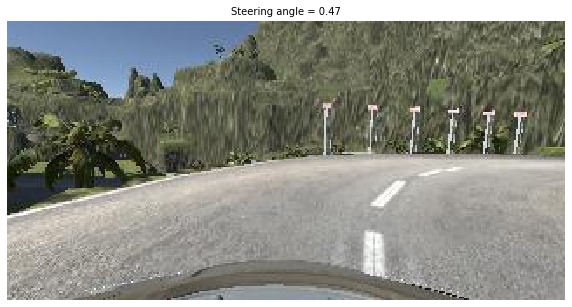

In [5]:
plt.figure(figsize=(10,10))
img_idx = random.randint(0, len(x))
plt.axis('off')
plt.title('Steering angle = '
          '{:2.2f}'.format(y[img_idx]), fontsize=10)
plt.imshow(cv2.cvtColor(x[img_idx], cv2.COLOR_BGR2RGB));

## Steering histogram

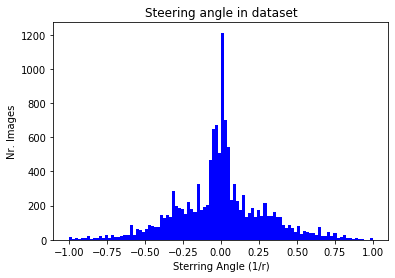

In [6]:
def visualize_steering_hist(data):
    plt.title('Steering angle in dataset')
    plt.hist(data, 100, facecolor='blue')
    plt.xlabel('Sterring Angle (1/r)')
    plt.ylabel('Nr. Images'),
    plt.show()

visualize_steering_hist(y)

## Too much center steering

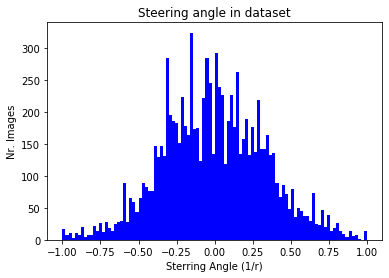

Left images 9406


In [7]:
def random_drop_steering_angle(p=0.3, limits = [-0.1, 0.1]):
    np.random.seed(42)

    where_y = np.where(np.logical_and(y>=limits[0], y<=limits[1]))
    mask = np.ones(y.shape, dtype=np.bool)
    
    for idx in where_y[0]:
        prob = 0.5 + (0.3 - 4.5 * np.abs(y[idx]))
        mask[idx] = np.random.choice([True, False], p=[1-prob, prob])

    return x[mask], y[mask]

xx, yy = random_drop_steering_angle()

if USE_BINS:
    xx, yy = get_data_bins(xx, yy)

visualize_steering_hist(yy)
print("Left images", yy.shape[0])

## Split between train and validation

In [8]:
TEST_SIZE = 1000

x, y = sklearn.utils.shuffle(xx, yy, random_state=0)
# Convert to float for the model
x = x.astype(np.float32)

x_test = x[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]

x = x[:-TEST_SIZE]
y = y[:-TEST_SIZE]

print("Train data", x.shape[0])
print("Validation data", y_test.shape[0])

Train data 8406
Validation data 1000


## Train the model

If you want to see the tensorboard output on how the training is going run:
```
tensorboard --logdir logs/fit
```

## Train Configuration

In [9]:
EPOCHS = 15
BATCH_SIZE = 16

In [10]:
model = PilotNet()

if USE_BINS:
    loss = "sparse_categorical_crossentropy"
    model_name = "model_bins"
else:
    loss = "mse"
    model_name = "model"

try:
    print("Trying to load model from disk...")
    model.load(model_name)
    print("Loaded model from disk")
except:
    print("Bulding the model and saving it to disk...")
    model.compile(loss=loss, optimizer='adam')
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=0)
    
    model.fit(x, y, 
              validation_data=(x_test, y_test),
              shuffle=True,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks=[tensorboard_callback]
             );

    model.save(model_name)
    print("Saved model to disk")

Trying to load model from disk...
Loaded model from disk


Number of missmatches 192


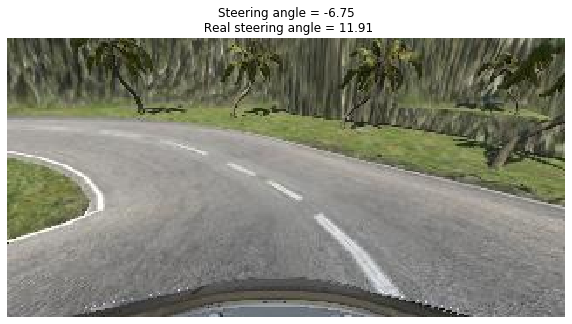

In [11]:
# Check on the test dataset
def to_degrees(y):
    return y * 25

ERROR_THRESHOLD = 3 # If bigger than 3 degrees
if USE_BINS:
    pred = to_degrees(np.argmax(model.predict(x_test), axis=1))
else:
    pred = to_degrees(model.predict(x_test)).squeeze(1)

y_test_d = to_degrees(y_test)
error = np.abs(y_test_d - pred)

print("Number of missmatches", (error >= ERROR_THRESHOLD).sum())

error_idx_start = np.where(error >= ERROR_THRESHOLD)
img_idx = np.argmax(error)

plt.figure(figsize=(10,10))
plt.axis('off')

plt.title('Steering angle = '
          '{:2.2f}\n '
          'Real steering angle = {:2.2f}'.format(pred[img_idx], y_test_d[img_idx], fontsize=10))

plt.imshow(cv2.cvtColor(x_test[img_idx].astype(np.uint8), cv2.COLOR_BGR2RGB));

##  1. Generate images with random transform

In [12]:
x_transforms = deepcopy(x_test)
y_transforms = deepcopy(y_test)

x_new_t = []
y_new_t = []

funcs = {
    "shear": apply_shear,
    "flip": apply_flip,
    "brightness": apply_brightness
}

for i, d in enumerate(x_transforms):
    t = y_transforms[i]
    val = random.choice(["shear", "flip", "brightness"])
    
    new_d, new_t = funcs[val](d, t)
    x_new_t.append(new_d)
    y_new_t.append(new_t)
    
x_new_t = np.array(x_new_t)
y_new_t = to_degrees(np.array(y_new_t))

In [13]:
## Check on the test dataset with transformations
if USE_BINS:
    pred_trans = to_degrees(np.argmax(model.predict(x_new_t), axis=1));
else:
    pred_trans = to_degrees(model.predict(x_new_t).squeeze(1));
error = np.abs(y_new_t - pred_trans)

error_idx = np.where(error >= ERROR_THRESHOLD)

# Should also be ok even if we use USE_BINS = true
# because the difference should be 0
print("Number of missmatches", (error >= ERROR_THRESHOLD).sum())

Number of missmatches 356


### Show the results

Image idx  44


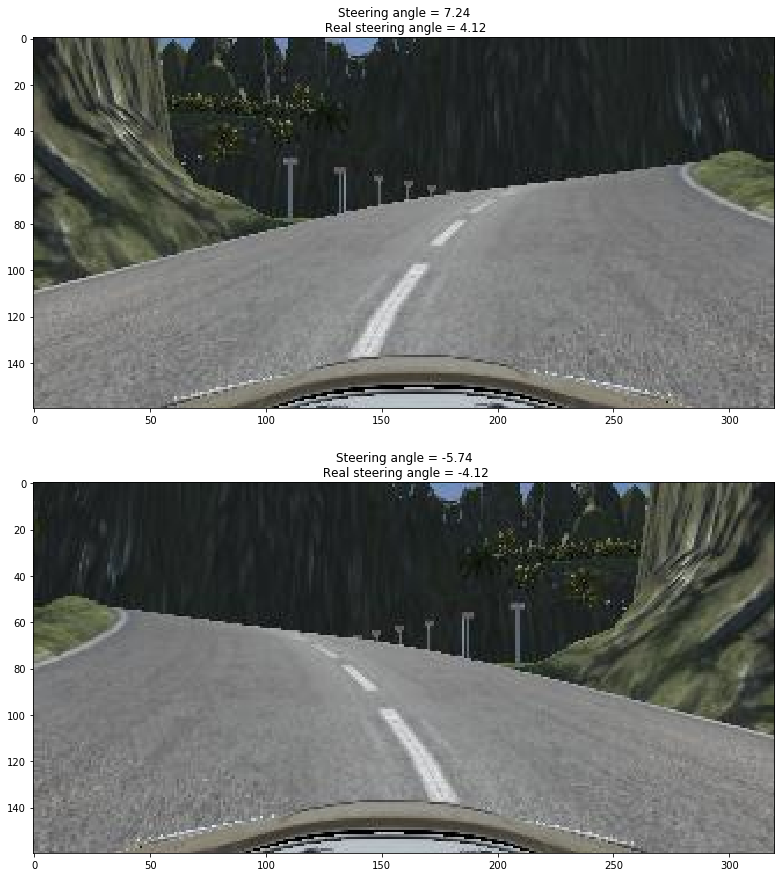

In [14]:
img_idx = 3
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_figheight(15)
fig.set_figwidth(15)
img_idx = np.random.choice([x for x in error_idx[0] if x not in error_idx_start[0]])
print("Image idx ", img_idx)

ax1.title.set_text('Steering angle = '
           '{:2.2f}\n '
           'Real steering angle = {:2.2f}'.format(pred_trans[img_idx], y_new_t[img_idx], fontsize=10))
ax1.imshow(cv2.cvtColor(x_new_t[img_idx].astype(np.uint8), cv2.COLOR_BGR2RGB));

ax2.title.set_text('Steering angle = '
           '{:2.2f}\n '
           'Real steering angle = {:2.2f}'.format(pred[img_idx], to_degrees(y_test[img_idx]), fontsize=10))
ax2.imshow(cv2.cvtColor(x_test[img_idx].astype(np.uint8), cv2.COLOR_BGR2RGB));

## 2.Fast Gradient Sign Method
https://arxiv.org/pdf/1412.6572.pdf

In [43]:
eps = [0.01, 0.05, 0.15, 0.5]#, 1.0]#, 2.5]#, 5, 10]

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        if USE_BINS:
            loss = tf.keras.losses.SparseCategoricalCrossentropy(input_label, prediction)
        else:
            loss = tf.keras.losses.MSE(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

y_test = np.array(y_test, dtype=np.float32)
perturbations = create_adversarial_pattern(tf.convert_to_tensor(x_test),
                                           tf.convert_to_tensor(y_test))

for e in eps:
    x_mod = x_test + e * perturbations
    pred_adv = to_degrees(model.predict(x_mod).squeeze(1))

        
    error = np.abs(to_degrees(y_test) - pred_adv)
    print("Number of missmatches for eps value of {0}".format(e), (error >= ERROR_THRESHOLD).sum())

Number of missmatches for eps value of 0.01 192
Number of missmatches for eps value of 0.05 196
Number of missmatches for eps value of 0.15 210
Number of missmatches for eps value of 0.5 287


### Show the results 

Image idx  954


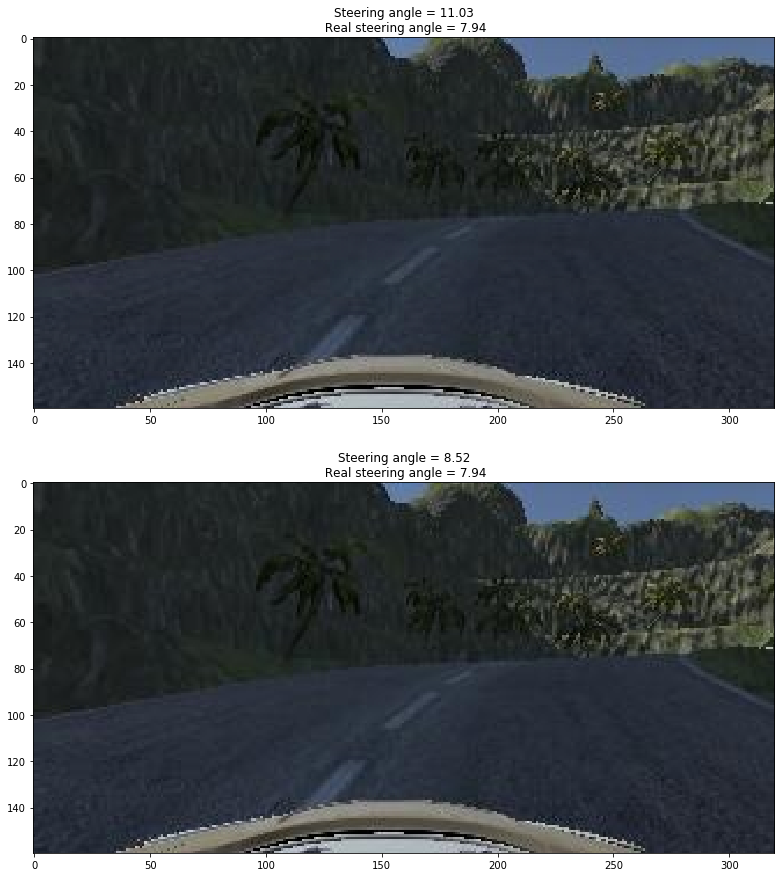

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1)
y_test_d = to_degrees(y_test)
error = np.abs(y_test_d - pred_adv)

imgs_idx = np.where(error >= ERROR_THRESHOLD)

img_idx = np.random.choice([x for x in imgs_idx[0] if x not in error_idx[0]])
print("Image idx ", img_idx)


fig.set_figheight(15)
fig.set_figwidth(15)

ax1.title.set_text('Steering angle = '
           '{:2.2f}\n '
           'Real steering angle = {:2.2f}'.format(pred_adv[img_idx], y_test_d[img_idx], fontsize=10))
ax1.imshow(cv2.cvtColor(x_mod[img_idx].numpy().astype(np.uint8), cv2.COLOR_BGR2RGB));

ax2.title.set_text('Steering angle = '
           '{:2.2f}\n '
           'Real steering angle = {:2.2f}'.format(pred[img_idx], y_test_d[img_idx], fontsize=10))
ax2.imshow(cv2.cvtColor(x_test[img_idx].astype(np.uint8), cv2.COLOR_BGR2RGB));

## 3.One pixel attack
Implemented only for bins

https://arxiv.org/abs/1710.08864

Diferential evolution algorithm for black-box optimization problems - derivative-free optimizations.

Nice tutorial explaining how differential evolution works [here](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/).

In [ ]:
def change_pixel(pixels, img):
    if pixels.ndim < 2:
        pixels = np.array([pixels])

    tile = [len(pixels)] + [1]*(pixels.ndim+1)
    imgs = np.tile(img, tile)
    pixels = pixels.astype(int)
    
    for x, img in zip(pixels, imgs):
        p = np.split(x, len(x) // 5)
        for pixel in p:
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs


def predict_bin(pixel, img, target_idx):
    img_perturbed = change_pixel(pixel, img)
    pred = model.predict(img_perturbed)[0]
    
    return pred


def is_success(x, img, target):
    attack_image = change_pixel(x, img)
    steer_val = np.argmax(model.predict(attack_image), axis=1)[0]
    print(steer_val, target)
    if steer_val != target:
        return True
    
    return None

    
def one_pixel_attack(img_idx, maxiter=100, size=1000):
    limits = [(0,160), (0,320), (0,256), (0,256), (0,256)] * 3
    population = max(1, size // len(limits))
    
    predict_fn = lambda xs: predict_bin(xs, x_test[img_idx], y_test[img_idx])
    callback_fn = lambda x, convergence: is_success(x, x_test[img_idx], y_test[img_idx])
    
    attack_result = differential_evolution(
        predict_fn,
        limits,
        maxiter=maxiter,
        popsize=population,
        recombination=1,
        polish=False,
        callback=callback_fn)
    
    attack_image = change_pixels(attack_result.x, x_test[img_idx])
    pred = np.argmax(model.predict(np.array([attack_image])), axis=1)[0]
    
    print(attack_result.x)
    x, y, _, _, _ = attack_result.x
    print(x_test[img_idx][int(x), int(y)])
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figheight(15)
    
    ax1.title.set_text('Real steering angle = {:2.2f}'.format(y_test[img_idx], fontsize=10))
    ax1.imshow(cv2.cvtColor(x_test[img_idx].astype(np.uint8), cv2.COLOR_BGR2RGB));
    
    print(np.where(x_test[img_idx].astype(np.uint8) != attack_image.astype(np.uint8)))
    ax2.title.set_text('Value Predicted = {:2.2f}'.format(pred, fontsize=10))
    ax2.imshow(cv2.cvtColor(attack_image.astype(np.uint8), cv2.COLOR_BGR2RGB));


one_pixel_attack(432)

## TODO

- [ ] Create a settings file from where to take a configuration (correction for the angle, image augmentation parameters, etc.) (Better idea -- add it directly in the notebook)
- [ ] Add more parameters for image augmentation - currently they are hardcoded
- [x] Add requirements file for the notebook
- [x] Add more attacks - added one pixel attack
- [x] Better analyze the data - histogram, make it less bias for center
- [x] Split it into bins
- [x] Check if some of the images have "something common" for the attack
- [x] Better visualisation for training
- [ ] Test it on real data - need to find some real datasets